In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import tqdm as tqdm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('train.csv', encoding = 'cp949')
test = pd.read_csv('test.csv',encoding = 'cp949')
submission = pd.read_csv('sample_submission.csv', encoding = 'cp949')

In [3]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [4]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 결측치 확인하기
print('train 결측치', '\n' ,train.isnull().sum())
print('test 결측치', '\n', test.isnull().sum())

train 결측치 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64
test 결측치 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


- test에 엄청 많은 결측치가 포함되어있다.

In [6]:
# 데이터 타입확인하기
print('train.shape',train.shape)
print('test.shape', test.shape)

train.shape (122400, 10)
test.shape (10080, 9)


## 종속변수 확인해보기

In [7]:
# 전력사용량(kWh)로 표시해주기 너무 불편함으로 target이라고 바꿔주자.
train=train.rename(columns = {'전력사용량(kWh)': 'target'})

test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

Text(0.5, 1.0, 'boxenplot of target')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


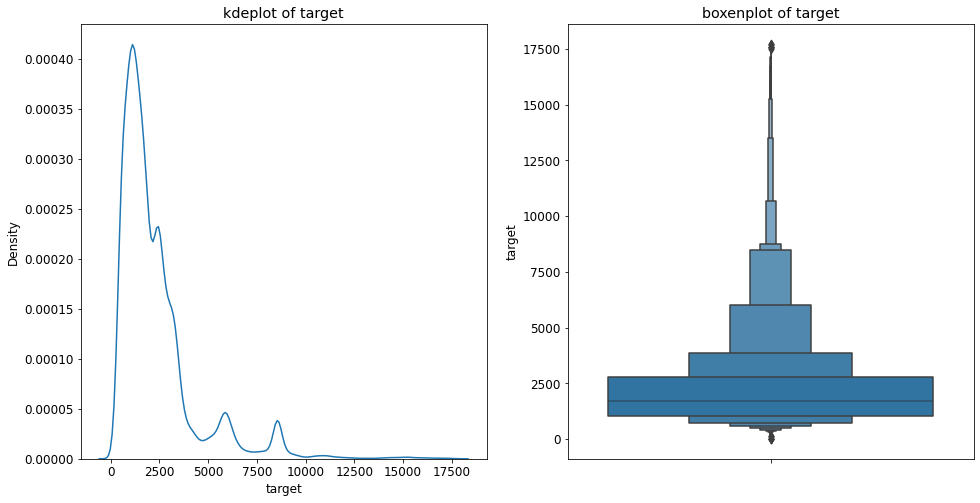

In [8]:
# 정규화가 되어있지 않고 1000~2500까지 많은데이터가 분포되어잇다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(data = train, x = 'target', ax = ax[0])
ax[0].set_title('kdeplot of target')

sns.boxenplot(data = train, y = 'target', ax = ax[1])
ax[1].set_title('boxenplot of target')

- 이상치가 많은것으로 보여진다.

<AxesSubplot:>

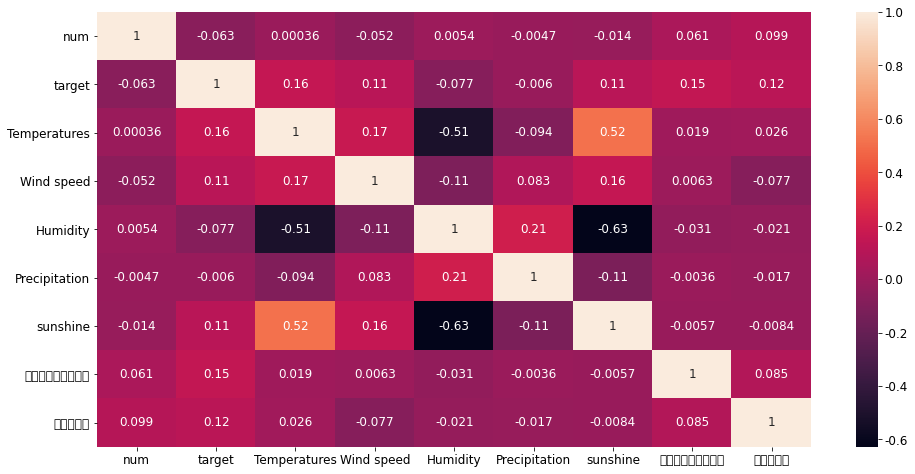

In [9]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
train=train.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm)':'Precipitation','일조(hr)':'sunshine'})

train_corr=train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

### test의 결측값이 결측값이 아닌것을 확인했고 우리는 interpolate를 사용하여 채워주자.

In [10]:
# 결측치 채우기
col = ['Temperatures','Wind speed','Humidity','Precipitation','sunshine']
for i in col:
    test[i] = test[i].interpolate()

In [11]:
test

,num,date_time,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,NaN,NaN
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,NaN,NaN
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,NaN,NaN
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,NaN,NaN
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,NaN,NaN
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,NaN,NaN
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,NaN,NaN


## num(한 건물을 나타낸다.)

In [12]:
train.num.unique()
# 60개의 건물이 있다는 것을 확인했다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

<AxesSubplot:xlabel='num', ylabel='target'>

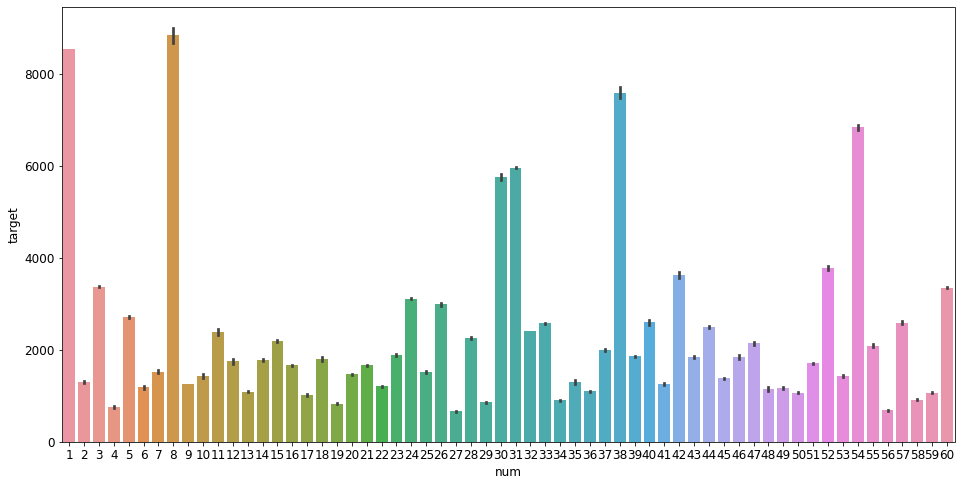

In [13]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'num', y = 'target')

- 각 건물마다 전기 사용량이 제각각 다른 것을 확인했다.

<AxesSubplot:xlabel='target', ylabel='Count'>

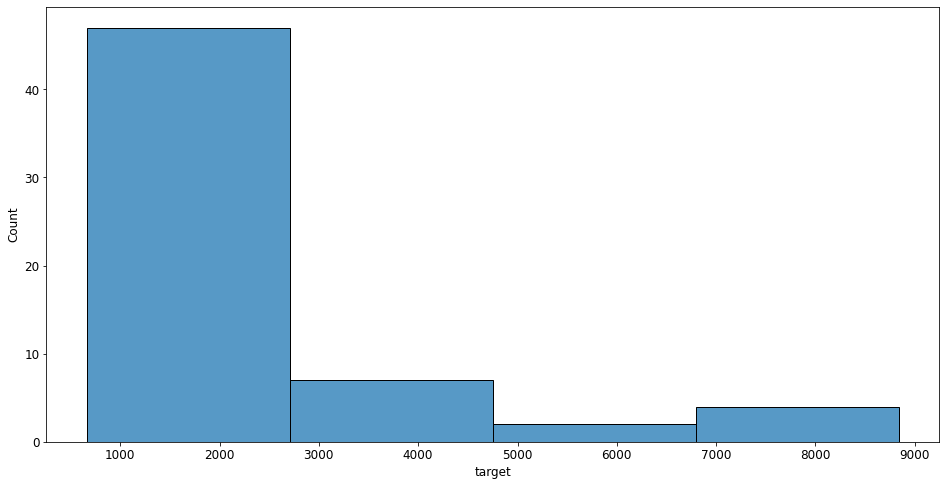

In [14]:
# 4개로 했을 때 가장 두드러지게 나타난다.
sns.histplot(train.groupby('num')['target'].mean(),bins = 4)

In [15]:
mapping=pd.qcut(train.groupby('num')['target'].mean(),4 ,labels = [0,1,2,3])
train['num_target'] = train['num'].map(mapping)
test['num_target'] = test['num'].map(mapping)

<AxesSubplot:xlabel='num_target', ylabel='target'>

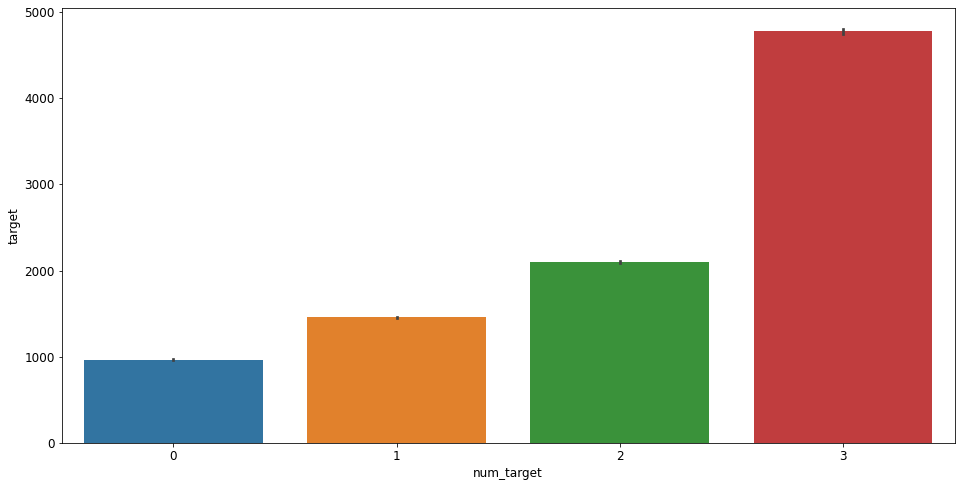

In [16]:
sns.barplot(data = train, x = 'num_target', y = 'target')

## date_time

In [17]:
# 월, 일, 시간 별로 나누는 함수 만들기
def date_time(df, columns = 'date_time'):
    df['month'] = df[columns].apply(lambda x: x[5:7])
    df['day'] = df[columns].apply(lambda x:x[8:10])
    df['hour'] = df[columns].apply(lambda x:x[11:])
    return df
# train데이터에 적용시켜주기
train = date_time(train)

In [18]:
# 평일과 공휴일 함수 만들기
def weekday(df, columns = 'date_time'):
    df[columns]=pd.to_datetime(df[columns])
    df['weekday'] = df[columns].apply(lambda x:x.weekday())
    df['weekday'] = df['weekday'].apply(lambda x:1 if x >4 else 0)
    return df
# 평일과 공휴일 함수 적용시켜주기
train=weekday(df = train)

### 월별 데이터 확인해보기

Text(0.5, 1.0, 'boxnplot - month of target')

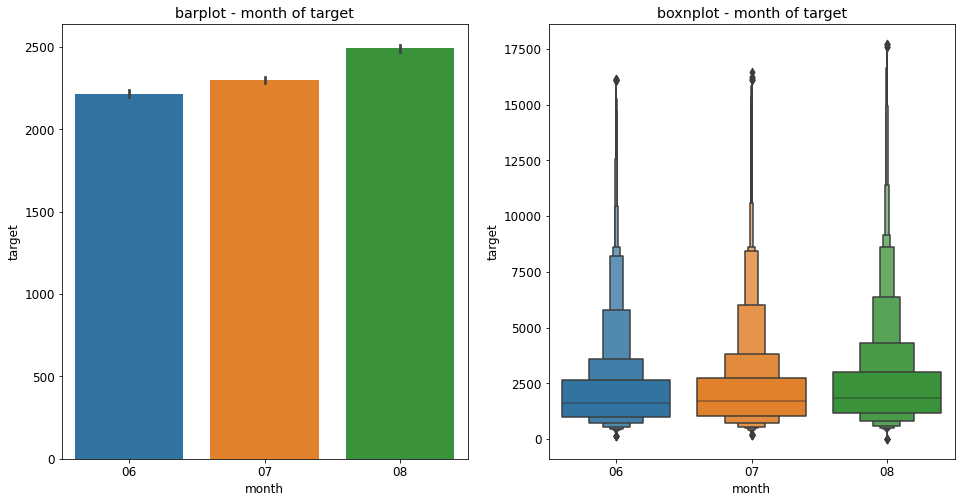

In [19]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('barplot - month of target')

sns.boxenplot(data = train, x= 'month', y = 'target', ax = ax[1])
ax[1].set_title('boxnplot - month of target')

- 시간이 지날수록 더 많은 전력량을 사용하는 것을 알 수 있다.
- 우리는 test값이 8월달의 데이터만 가지고 있기 때문에 어떻게 분석해줄지는 확인해 봐야겠다.

### 일별 확인해 보기

Text(0.5, 1.0, 'boxenplot - day of target')

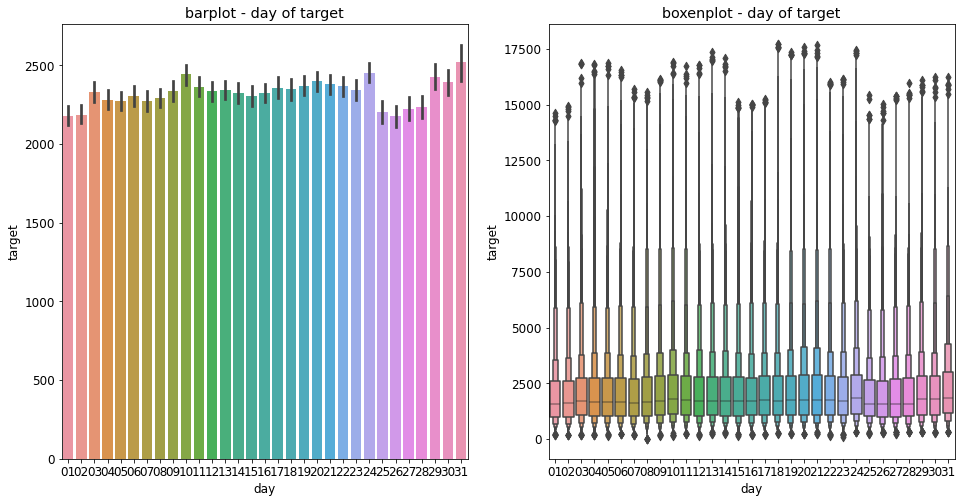

In [20]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', ax = ax[0])
ax[0].set_title('barplot - day of target')

sns.boxenplot(data = train, x = 'day', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - day of target')

- 일별로 큰 차이가 있다고 말 할수는 없을 것 같다

### 시간별 확인해 보기

Text(0.5, 1.0, 'boxenplot - hour of target')

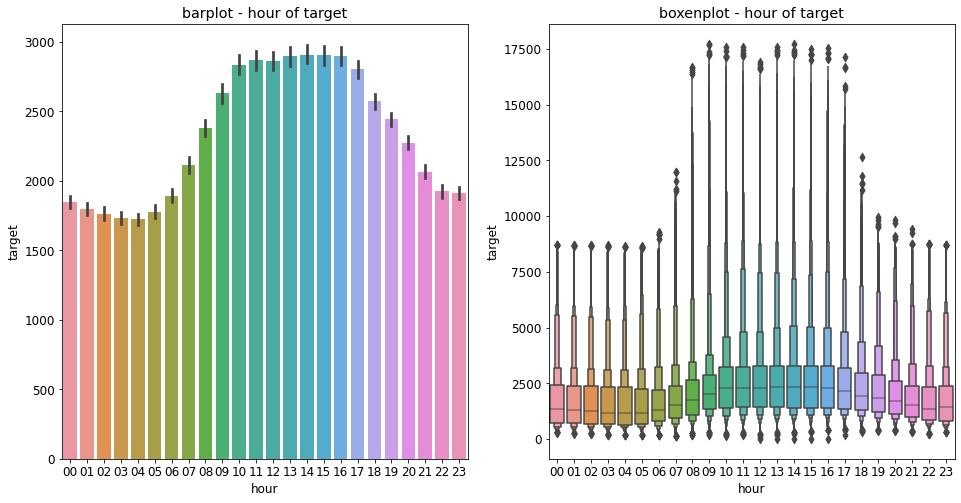

In [21]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', ax = ax[0])
ax[0].set_title('barplot - hour of target')

sns.boxenplot(data = train, x = 'hour', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - hour of target')

- 시간별로 확실한 차이가 있다고 말할 수 있다.
- 사람들이 활동하는 시간에 전력소모량이 가장 많은 것을 알 수 있다.

### 평일과 주말로 비교해보기

Text(0.5, 1.0, 'boxenplot of weekday')

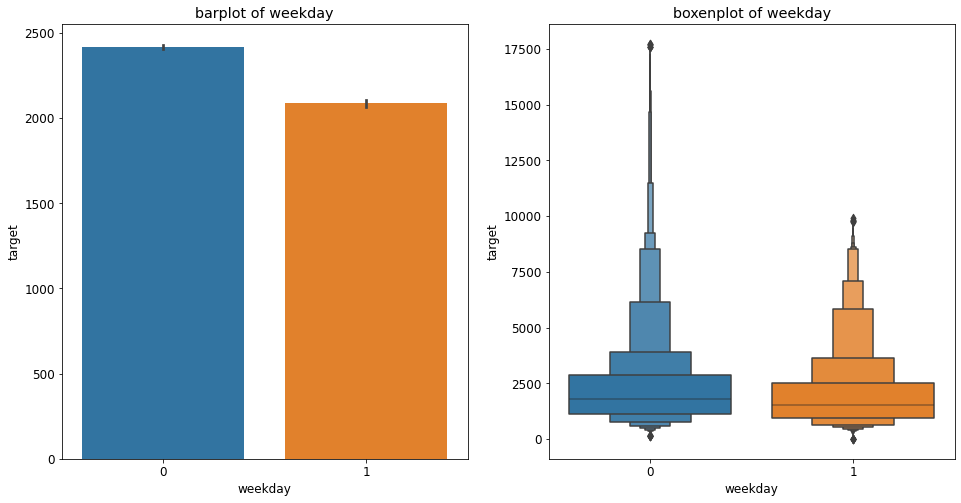

In [22]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('barplot of weekday')

sns.boxenplot(data = train, x = 'weekday', y  ='target', ax = ax[1])
ax[1].set_title('boxenplot of weekday')

- 평일에 많은 전력량을 소모하는 것으로 나타낸다.

Text(0.5, 1.0, 'weekday month target')

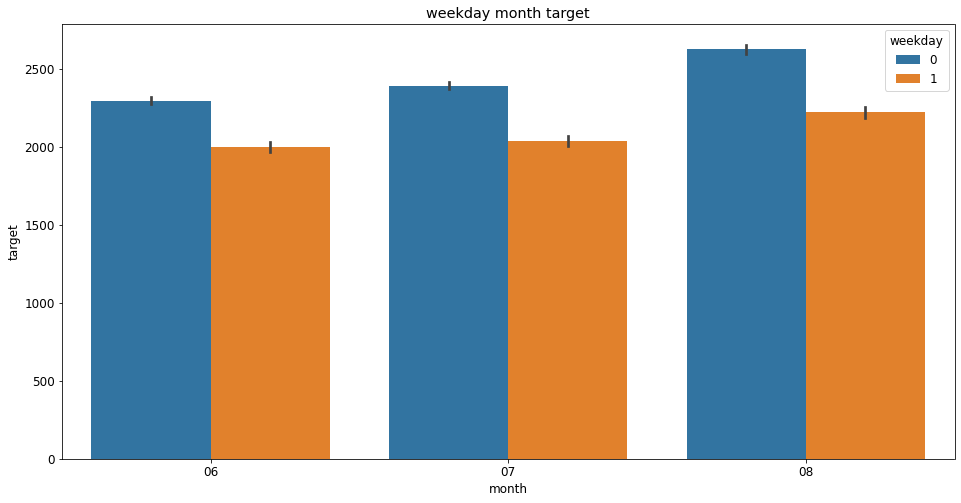

In [23]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', hue = 'weekday')
plt.title('weekday month target')

Text(0.5, 1.0, 'weekday day target')

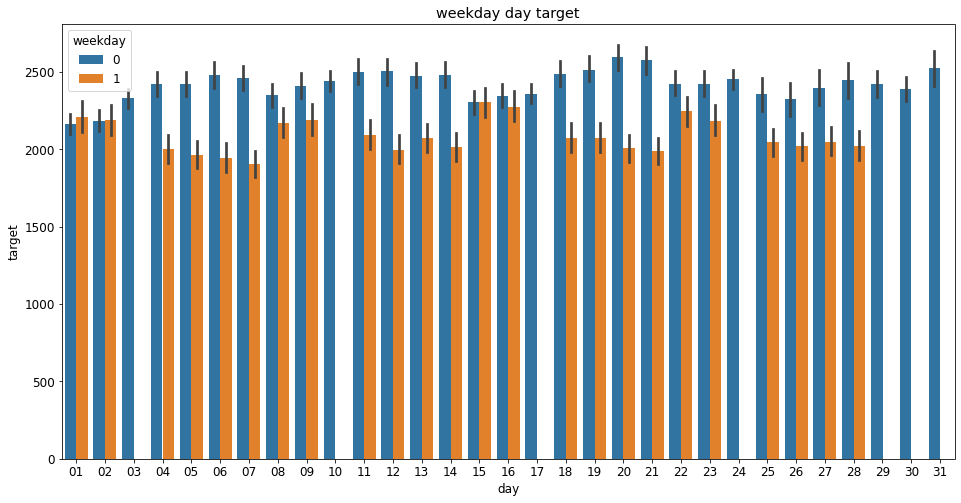

In [24]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', hue = 'weekday')
plt.title('weekday day target')

- 주말이 없는 날짜가 있기 때문에 표시가 안된 부분도 있다.

Text(0.5, 1.0, 'weekday hour target')

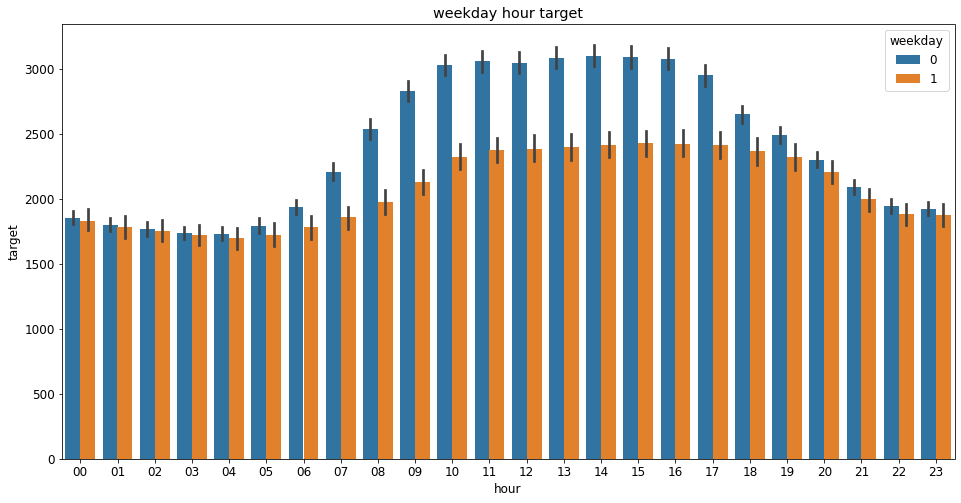

In [25]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')
plt.title('weekday hour target')

## 기온(Temperatures)

In [26]:
# min = 11.1, max = 36.3
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

<AxesSubplot:xlabel='Temperatures', ylabel='Density'>

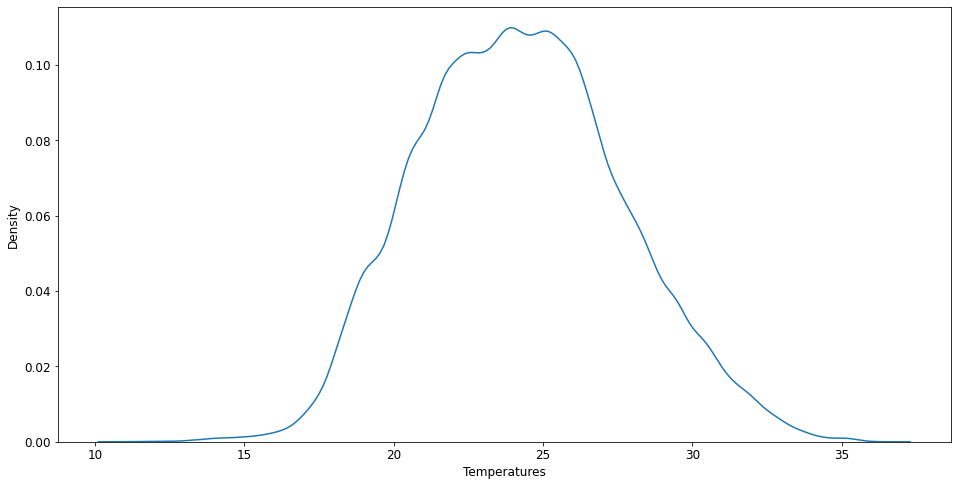

In [27]:
sns.kdeplot(data = train, x = 'Temperatures')

<AxesSubplot:xlabel='Temperatures', ylabel='target'>

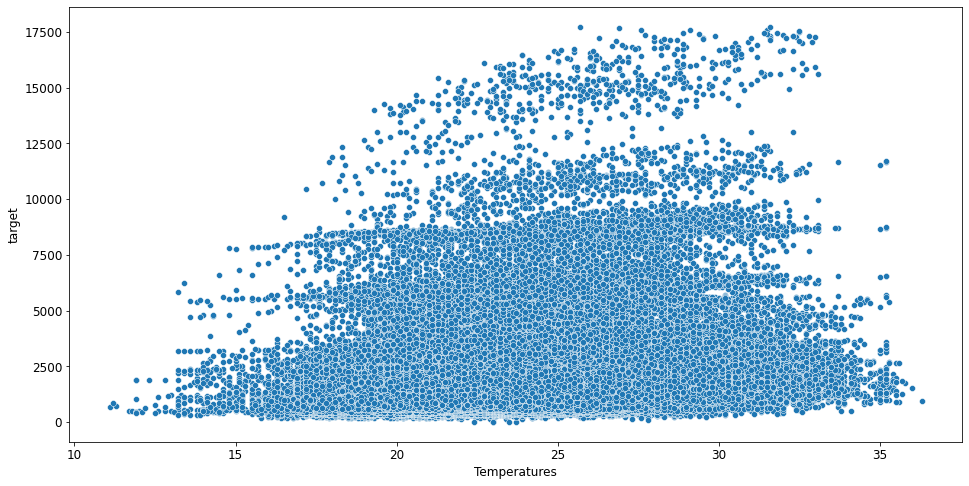

In [28]:
sns.scatterplot(data = train, x = 'Temperatures', y = 'target')

In [29]:
# 이 데이터는 온도에 따라 나눠주는 것이기 때문에 train의 데이터롤 그대로 가지고 와야한다.
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

In [30]:
train.loc[21.800000 >= train['Temperatures'], 'temperature_binning'] = 0
train.loc[(21.800000 < train['Temperatures']) & (train['Temperatures'] < 24.200000), 'temperature_binning'] = 1
train.loc[(24.200000 < train['Temperatures']) & (train['Temperatures'] < 26.500000), 'temperature_binning'] = 2
train.loc[(26.500000 < train['Temperatures']), 'temperature_binning'] = 3

test.loc[21.800000 >= test['Temperatures'], 'temperature_binning'] = 0
test.loc[(21.800000 < test['Temperatures']) & (test['Temperatures'] < 24.200000), 'temperature_binning'] = 1
test.loc[(24.200000 < test['Temperatures']) & (test['Temperatures'] < 26.500000), 'temperature_binning'] = 2
test.loc[(26.500000 < test['Temperatures']), 'temperature_binning'] = 3

Text(0.5, 1.0, 'temperature_binning boxenplot')

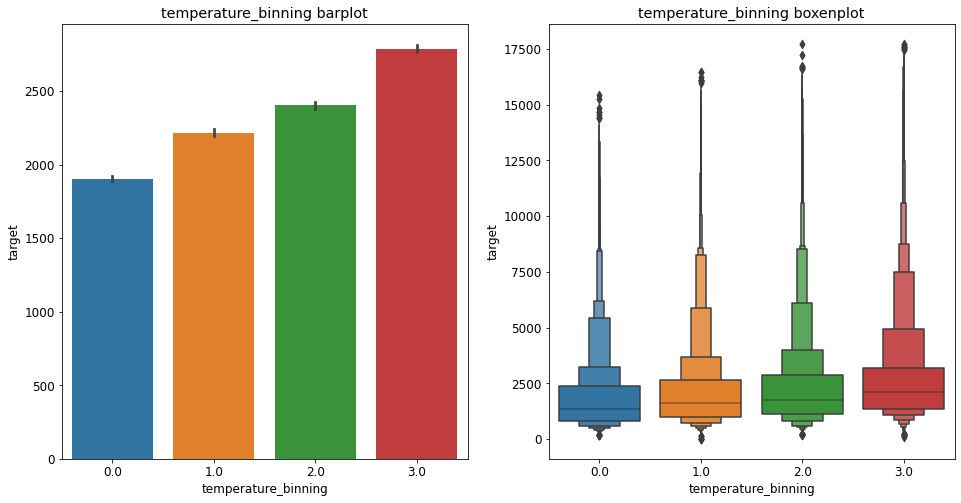

In [31]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[0])
ax[0].set_title('temperature_binning barplot')

sns.boxenplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[1])
ax[1].set_title('temperature_binning boxenplot')

- 이상치가 많은것으로 보이고 이상치는 사용 용도인 num에 따라서 다른 것 같다 우리는 num을 target 별로 군집화 하는게 어떨지 생각해 본다.
- 그게 안된다면 target을 포함한 변수들로 건물의 쓰이는 용도를 군집화 해주는 방법도 좋은 것 같다.

## 풍향(Wind speed)

In [32]:
train['Wind speed'].value_counts()

1.1     4241
1.6     3911
1.5     3831
1.2     3811
1.4     3746
        ... 
16.3       1
16.8       1
11.9       1
15.4       1
16.6       1
Name: Wind speed, Length: 155, dtype: int64

<AxesSubplot:xlabel='Wind speed', ylabel='target'>

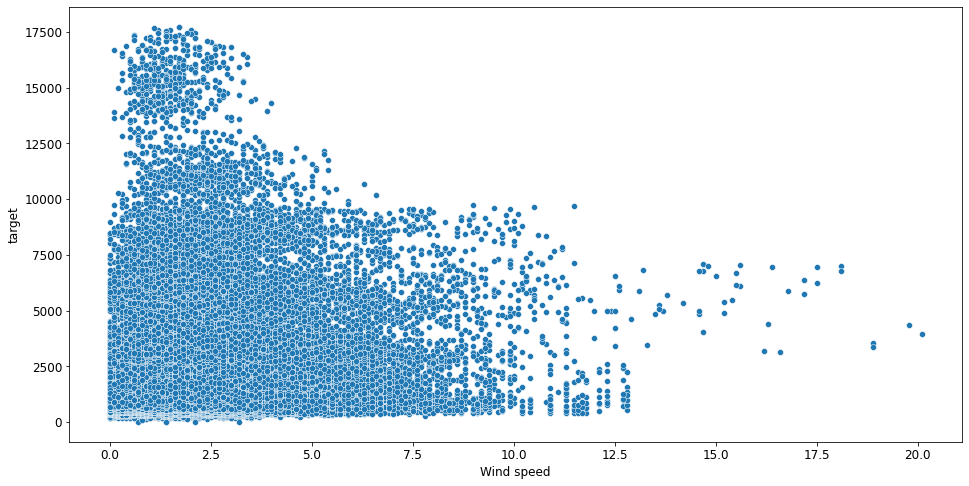

In [33]:
sns.scatterplot(data =train, x = 'Wind speed', y = 'target')

## 습도(Humidity)

In [34]:
train['Humidity'].value_counts

<bound method IndexOpsMixin.value_counts of 0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64>

<AxesSubplot:xlabel='Humidity', ylabel='target'>

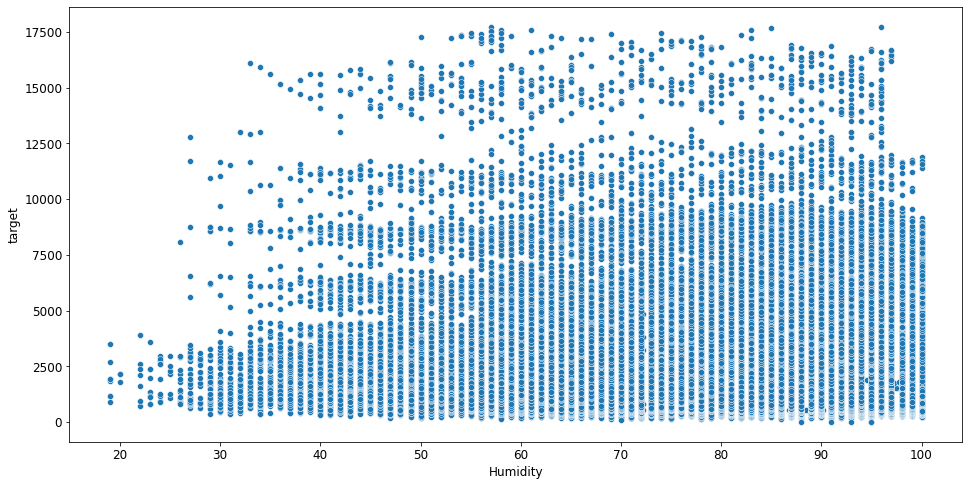

In [35]:
sns.scatterplot(data = train, x = 'Humidity', y = 'target')

## 강수량(Precipitation)

In [36]:
train['Precipitation'].value_counts()

0.0     103473
0.1       2508
0.2       1644
0.3       1171
0.5        830
         ...  
25.1         1
25.2         1
27.9         1
31.0         1
54.6         1
Name: Precipitation, Length: 296, dtype: int64

<AxesSubplot:xlabel='Precipitation', ylabel='target'>

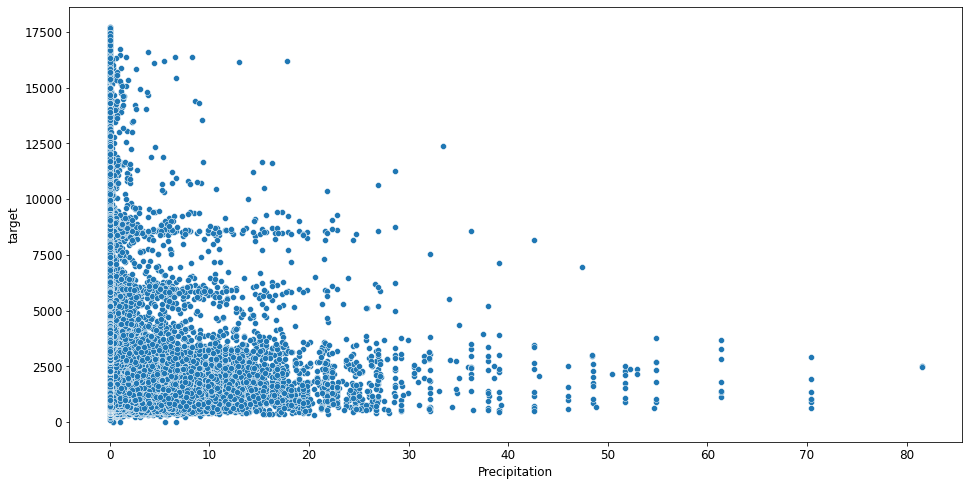

In [37]:
sns.scatterplot(data = train, x = 'Precipitation', y = 'target')

## 일조(sunshine)

In [38]:
train['sunshine'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: sunshine, dtype: int64

<AxesSubplot:xlabel='sunshine', ylabel='target'>

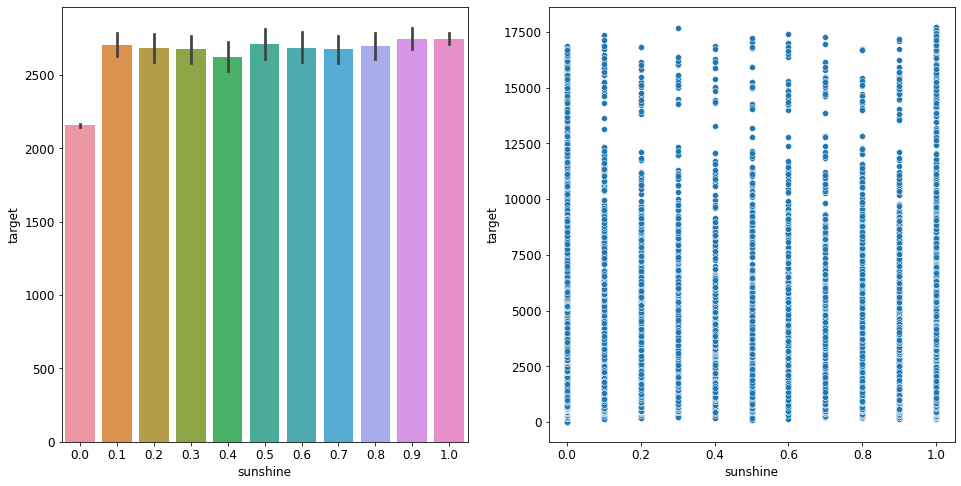

In [39]:
fig, ax = plt.subplots(ncols = 2)
sns.barplot(data = train, x = 'sunshine', y = 'target', ax = ax[0])

sns.scatterplot(data = train, x = 'sunshine', y = 'target', ax = ax[1])

## 비전기냉방설비운영

<AxesSubplot:xlabel='비전기냉방설비운영', ylabel='target'>

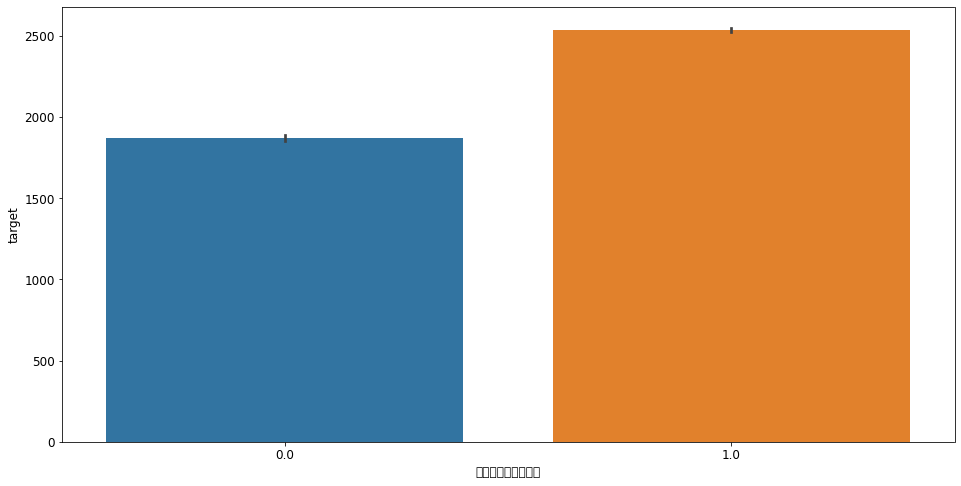

In [40]:
sns.barplot(data = train, x = '비전기냉방설비운영', y = 'target')

In [41]:
# 비전기냉방설비운영을 안하고있다가 하고 있는 곳을 확인했지만 그런 곳은 확인하지 못했다.
비전기냉방설비운영_0=list(train[train['비전기냉방설비운영'] == 0]['num'].unique())
비전기냉방설비운영_1=list(train[train['비전기냉방설비운영'] == 1]['num'].unique())

for i in 비전기냉방설비운영_0:
    비전기냉방설비운영_1.append(i)


len(비전기냉방설비운영_1) == len(train['num'].unique())

True

## 태양광보유

<AxesSubplot:xlabel='태양광보유', ylabel='target'>

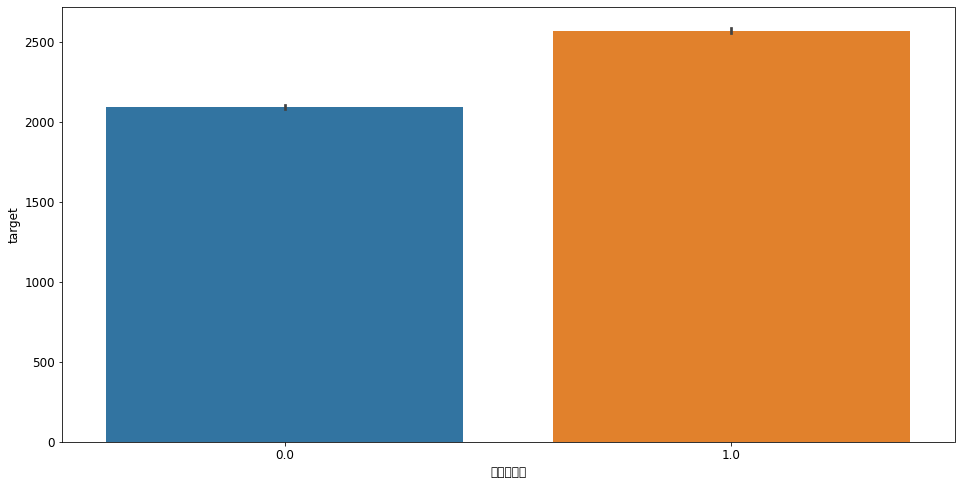

In [42]:
sns.barplot(data = train, x = '태양광보유', y = 'target')

In [43]:
# 태양광을 보유하지 않다가 보유한 건물이 있는지 확인해 보자.
태양광보유_0 = list(train[train['태양광보유'] == 0]['num'].unique())
태양광보유_1 = list(train[train['태양광보유'] == 1]['num'].unique())

for i in 태양광보유_0:
    태양광보유_1.append(i)
    
len(태양광보유_1) == len(train['num'].unique())

True

In [44]:
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 0), 'new_column'] = 0
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 1), 'new_column'] = 1
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 0), 'new_column'] = 2
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 1), 'new_column'] = 3

<AxesSubplot:xlabel='new_column', ylabel='target'>

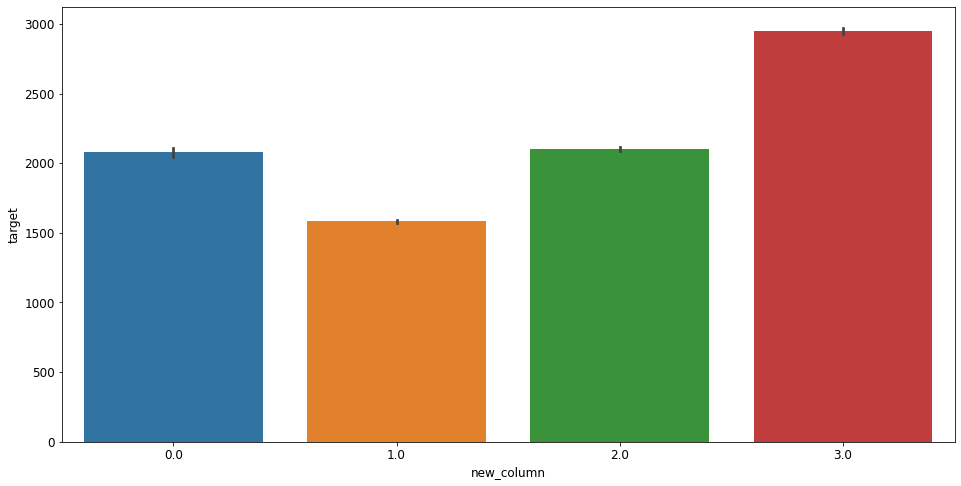

In [45]:
sns.barplot(data = train, x = 'new_column', y = 'target')

## 체감온도 구하기

In [46]:
train['Humidity']

0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64

In [47]:
train['Humidity'].min()

19.0

In [48]:
def winter_temperature(df = None):
    df['Wind speed km/h'] = df['Wind speed'].apply(lambda x: x*3.6)
    def tem(x):
        V = 'Wind speed km/h'
        T = 'Temperatures'
        temperature= 13.12 + (0.6215*x[T]) - 11.37*((x[V])**0.16) + (0.3965*(x[V] **0.16)*x[T])
        return temperature
    temperature = tem(df)
    df['겨울철 체감온도'] = temperature
    df.drop('Wind speed km/h', axis = 1, inplace = True)
    return df


def summer_temperature(df = None):
    
    def tem1(x):
        T = 'Temperatures'
        H = 'Humidity'
        temperature = x[T] + ((x[H] - 50)* 0.1)
        return temperature
    temperature = tem1(df)
    df['여름철 체감온도'] = temperature
    
    return df

In [49]:
# train= winter_temperature(train)
# test = winter_temperature(test)
                                      
train = summer_temperature(train)
test = summer_temperature(test)

습도 50%를 기준으로 10%가 올라가면 플러스 1도, 떨어지면 마이너스 1도로 치고 폭염주의보와 경보도 기온이 아니라 체감온도를 기준으로 발령하기로 했습니다 

Text(0.5, 1.0, 'summer temperature')

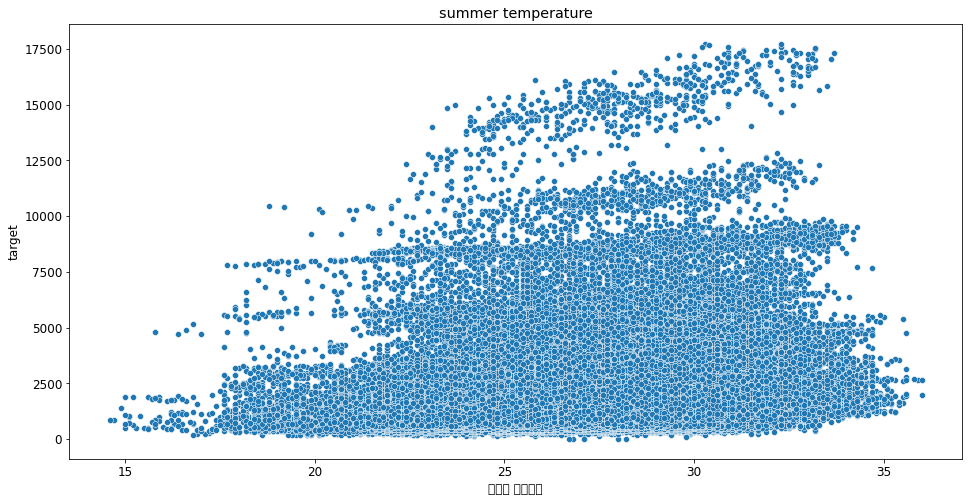

In [50]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.scatterplot(data = train, x = '겨울철 체감온도', y = 'target', ax = ax[0])
# ax[0].set_title('winter temperature')

sns.scatterplot(data = train, x = '여름철 체감온도', y = 'target')
plt.title('summer temperature')

## 불쾌지수 구하기

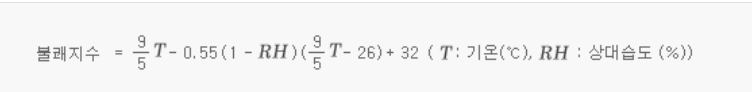

In [51]:
def 불쾌지수구하기(df = None):
    def 불쾌지수구하기(x):
        T = 'Temperatures'
        H = 'Humidity'
        불쾌지수 = (9/5 * x[T]) - (0.55 * (1 - x[H]) * ((9 / 5 * x[T]) - 26)) + 32
        
        return 불쾌지수
    불쾌지수  = 불쾌지수구하기(df)
    df['불쾌지수'] = 불쾌지수
    
    return df

train=불쾌지수구하기(train)
test = 불쾌지수구하기(test)

## Test EDA

In [52]:
test = date_time(test)
test = weekday(df = test)

In [53]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [54]:
test.isnull().sum()

num                       0
date_time                 0
Temperatures              0
Wind speed                0
Humidity                  0
Precipitation             0
sunshine                  0
비전기냉방설비운영              7784
태양광보유                  8456
num_target                0
temperature_binning     125
여름철 체감온도                  0
불쾌지수                      0
month                     0
day                       0
hour                      0
weekday                   0
dtype: int64

In [55]:
print('3시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Temperatures']) - (len(test['Temperatures'])/3))
print('6시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Humidity']) - len(test['Humidity'])/ 6)
# 해당 결측치의 값과 같다.

3시간마다 데이터가 입력된다면 결측치의 값 : 6720.0
6시간마다 데이터가 입력된다면 결측치의 값 : 8400.0


- 기온, 풍속, 습도. 일조는 3시간마다 데이터가 입력되어 있다.
- 그러나 강수량은 6시간마다 데이터가 입력되어 있기 때문에 결측치도 다르다.
- 그래서 이 데이터를 어떻게 해주어야 할지 고민해 봐야겠다.

In [56]:
# Nan값으로 표시된 것은 전부 비전기냉방설비운영을 하지않는 사람인 것 같다.
test['비전기냉방설비운영'].value_counts()

1.0    2296
Name: 비전기냉방설비운영, dtype: int64

In [57]:
# Nan값으로 표시된 것은 전부 태양광보유를 하지 않은 사람이다.
test['태양광보유'].value_counts()

1.0    1624
Name: 태양광보유, dtype: int64

In [58]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 비전기냉방설비운영
for num in test['num'].unique():
    if len(test[test['num'] == num]['비전기냉방설비운영'].value_counts()) == 1:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 1
    else:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 0

In [59]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 태양광보유
for num in test['num'].unique():
    if len(test[test['num'] == num]['태양광보유'].value_counts()) == 1:
        test.loc[test['num'] == num, '태양광보유'] = 1
    else:
        test.loc[test['num'] == num, '태양광보유'] = 0

In [60]:
print(test['비전기냉방설비운영'].value_counts())
print(test['태양광보유'].value_counts())

1.0    6888
0.0    3192
Name: 비전기냉방설비운영, dtype: int64
0.0    5208
1.0    4872
Name: 태양광보유, dtype: int64


In [61]:
len(test)

10080

In [62]:
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 0), 'new_column'] = 0
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 1), 'new_column'] = 1
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 0), 'new_column'] = 2
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 1), 'new_column'] = 3

In [63]:
train.head()

,num,date_time,target,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유,num_target,month,day,hour,weekday,temperature_binning,new_column,여름철 체감온도,불쾌지수
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,3,06,01,00,0,0.0,0.0,21.8,347.964
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,3,06,01,01,0,0.0,0.0,21.8,353.930
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,3,06,01,02,0,0.0,0.0,21.6,335.750
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,06,01,03,0,0.0,0.0,21.2,299.390
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,3,06,01,04,0,0.0,0.0,21.2,292.830


In [64]:
test.head()

,num,date_time,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유,num_target,temperature_binning,여름철 체감온도,불쾌지수,month,day,hour,weekday,new_column
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,3,3.0,30.200000,1047.246000,08,25,00,0,0.0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,3,3.0,30.166667,1052.310333,08,25,01,0,0.0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,3,3.0,30.133333,1056.934667,08,25,02,0,0.0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,3,3.0,30.100000,1061.119000,08,25,03,0,0.0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0,3,3.0,29.866667,1050.458667,08,25,04,0,0.0


## 모델링

In [65]:
dummies = ['hour','weekday','new_column','temperature_binning','num_target'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
train_data=pd.get_dummies(data = train, columns = dummies)
test_data = pd.get_dummies(data = test, columns = dummies)

drop_columns = ['day','date_time','비전기냉방설비운영','태양광보유','Temperatures','num']
train_data = train_data.drop(drop_columns, axis = 1)
test_data = test_data.drop(drop_columns, axis = 1)

# month가 object로 들어가 있으므로 int형으로 바꿔준다.
train_data['month'] = train_data['month'].astype('int')
test_data['month'] = test_data['month'].astype('int')

In [66]:
test_data.interpolate()

,Wind speed,Humidity,Precipitation,sunshine,여름철 체감온도,불쾌지수,month,hour_00,hour_01,hour_02,...,new_column_1.0,new_column_2.0,new_column_3.0,temperature_binning_1.0,temperature_binning_2.0,temperature_binning_3.0,num_target_0,num_target_1,num_target_2,num_target_3
0,1.500000,74.000000,0.0,0.000000,30.200000,1047.246000,8,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1.366667,75.333333,0.0,0.000000,30.166667,1052.310333,8,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,1.233333,76.666667,0.0,0.000000,30.133333,1056.934667,8,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,1.100000,78.000000,0.0,0.000000,30.100000,1061.119000,8,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1.166667,79.666667,0.0,0.000000,29.866667,1050.458667,8,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,3.566667,66.000000,0.0,0.533333,30.233333,996.595000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1
10076,3.833333,67.000000,0.0,0.266667,29.966667,986.024000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1
10077,4.100000,68.000000,0.0,0.000000,29.700000,974.727000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1
10078,4.100000,68.000000,0.0,0.000000,29.700000,974.727000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [67]:
train_data.drop('temperature_binning_0.0', axis = 1 ,inplace = True)

In [68]:
test_data

,Wind speed,Humidity,Precipitation,sunshine,여름철 체감온도,불쾌지수,month,hour_00,hour_01,hour_02,...,new_column_1.0,new_column_2.0,new_column_3.0,temperature_binning_1.0,temperature_binning_2.0,temperature_binning_3.0,num_target_0,num_target_1,num_target_2,num_target_3
0,1.500000,74.000000,0.0,0.000000,30.200000,1047.246000,8,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1.366667,75.333333,0.0,0.000000,30.166667,1052.310333,8,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,1.233333,76.666667,0.0,0.000000,30.133333,1056.934667,8,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,1.100000,78.000000,0.0,0.000000,30.100000,1061.119000,8,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1.166667,79.666667,0.0,0.000000,29.866667,1050.458667,8,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,3.566667,66.000000,0.0,0.533333,30.233333,996.595000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1
10076,3.833333,67.000000,0.0,0.266667,29.966667,986.024000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1
10077,4.100000,68.000000,0.0,0.000000,29.700000,974.727000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1
10078,4.100000,68.000000,0.0,0.000000,29.700000,974.727000,8,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [69]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [77]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(train_data.drop('target', axis = 1), train_data['target'], test_size = 0.2, random_state = 42)
# catboost = CatBoostRegressor()
# catboost.fit(X_train,y_train)
# y_pred=catboost.predict(X_test)
# smape(y_test,y_pred)
# # lightgbm
# lgb=LGBMRegressor()
# lgb.fit(train_data.drop('target', axis = 1), train_data['target'])
# y_pred=lgb.predict(test_data)


# catboost
catboost = CatBoostRegressor(random_state= 42)
catboost.fit(train_data.drop('target', axis = 1), train_data['target'])
y_pred=catboost.predict(test_data)


# # xgboost
# xgb = XGBRegressor()
# xgb.fit(train_data.drop('target', axis = 1), train_data['target'])
# y_pred=xgb.predict(test_data)

Learning rate set to 0.091839
0:	learn: 1948.2331712	total: 29.2ms	remaining: 29.2s
1:	learn: 1851.4235232	total: 45.5ms	remaining: 22.7s
2:	learn: 1765.6320253	total: 61.4ms	remaining: 20.4s
3:	learn: 1691.8333357	total: 80.2ms	remaining: 20s
4:	learn: 1628.6545567	total: 104ms	remaining: 20.7s
5:	learn: 1574.1096143	total: 127ms	remaining: 21s
6:	learn: 1526.4147295	total: 147ms	remaining: 20.8s
7:	learn: 1486.5855216	total: 178ms	remaining: 22.1s
8:	learn: 1451.5212922	total: 200ms	remaining: 22s
9:	learn: 1422.3457620	total: 223ms	remaining: 22.1s
10:	learn: 1397.2140791	total: 240ms	remaining: 21.6s
11:	learn: 1375.7714467	total: 255ms	remaining: 21s
12:	learn: 1358.1244807	total: 272ms	remaining: 20.7s
13:	learn: 1342.1547502	total: 298ms	remaining: 21s
14:	learn: 1328.3430133	total: 317ms	remaining: 20.8s
15:	learn: 1317.1125589	total: 338ms	remaining: 20.8s
16:	learn: 1307.4317763	total: 360ms	remaining: 20.8s
17:	learn: 1299.1904943	total: 382ms	remaining: 20.9s
18:	learn: 129

156:	learn: 1143.7812521	total: 3.29s	remaining: 17.7s
157:	learn: 1143.5088949	total: 3.32s	remaining: 17.7s
158:	learn: 1143.3155900	total: 3.33s	remaining: 17.6s
159:	learn: 1142.7551514	total: 3.35s	remaining: 17.6s
160:	learn: 1142.4548507	total: 3.37s	remaining: 17.6s
161:	learn: 1142.2291083	total: 3.39s	remaining: 17.5s
162:	learn: 1141.8330470	total: 3.41s	remaining: 17.5s
163:	learn: 1141.2830935	total: 3.43s	remaining: 17.5s
164:	learn: 1141.0480785	total: 3.45s	remaining: 17.5s
165:	learn: 1140.6320393	total: 3.47s	remaining: 17.4s
166:	learn: 1140.0740761	total: 3.49s	remaining: 17.4s
167:	learn: 1139.5334259	total: 3.51s	remaining: 17.4s
168:	learn: 1139.1045946	total: 3.53s	remaining: 17.4s
169:	learn: 1138.5811024	total: 3.56s	remaining: 17.4s
170:	learn: 1138.3009026	total: 3.57s	remaining: 17.3s
171:	learn: 1137.6931644	total: 3.59s	remaining: 17.3s
172:	learn: 1136.8363507	total: 3.6s	remaining: 17.2s
173:	learn: 1136.3787259	total: 3.62s	remaining: 17.2s
174:	learn:

310:	learn: 1098.2202778	total: 6.44s	remaining: 14.3s
311:	learn: 1098.0996471	total: 6.46s	remaining: 14.2s
312:	learn: 1097.8326834	total: 6.47s	remaining: 14.2s
313:	learn: 1097.5573730	total: 6.5s	remaining: 14.2s
314:	learn: 1097.3704599	total: 6.52s	remaining: 14.2s
315:	learn: 1097.1398513	total: 6.54s	remaining: 14.2s
316:	learn: 1096.8859592	total: 6.56s	remaining: 14.1s
317:	learn: 1096.7419461	total: 6.58s	remaining: 14.1s
318:	learn: 1096.5866260	total: 6.6s	remaining: 14.1s
319:	learn: 1096.5010758	total: 6.61s	remaining: 14.1s
320:	learn: 1096.2645212	total: 6.63s	remaining: 14s
321:	learn: 1096.1582056	total: 6.65s	remaining: 14s
322:	learn: 1096.0470992	total: 6.67s	remaining: 14s
323:	learn: 1095.8495346	total: 6.69s	remaining: 14s
324:	learn: 1095.5991804	total: 6.71s	remaining: 13.9s
325:	learn: 1095.3034023	total: 6.74s	remaining: 13.9s
326:	learn: 1095.1384642	total: 6.76s	remaining: 13.9s
327:	learn: 1094.7421917	total: 6.78s	remaining: 13.9s
328:	learn: 1094.607

465:	learn: 1073.8203792	total: 9.6s	remaining: 11s
466:	learn: 1073.7437132	total: 9.62s	remaining: 11s
467:	learn: 1073.6775728	total: 9.63s	remaining: 11s
468:	learn: 1073.4858225	total: 9.65s	remaining: 10.9s
469:	learn: 1073.3327103	total: 9.68s	remaining: 10.9s
470:	learn: 1073.2376164	total: 9.69s	remaining: 10.9s
471:	learn: 1073.0338152	total: 9.71s	remaining: 10.9s
472:	learn: 1072.8586902	total: 9.73s	remaining: 10.8s
473:	learn: 1072.7638494	total: 9.76s	remaining: 10.8s
474:	learn: 1072.6594171	total: 9.78s	remaining: 10.8s
475:	learn: 1072.5283503	total: 9.8s	remaining: 10.8s
476:	learn: 1072.4509965	total: 9.83s	remaining: 10.8s
477:	learn: 1072.3850821	total: 9.84s	remaining: 10.7s
478:	learn: 1072.1895604	total: 9.86s	remaining: 10.7s
479:	learn: 1072.0981568	total: 9.88s	remaining: 10.7s
480:	learn: 1072.0509257	total: 9.9s	remaining: 10.7s
481:	learn: 1071.8738979	total: 9.93s	remaining: 10.7s
482:	learn: 1071.7539780	total: 9.94s	remaining: 10.6s
483:	learn: 1071.67

616:	learn: 1057.3642273	total: 12.7s	remaining: 7.88s
617:	learn: 1057.2832817	total: 12.7s	remaining: 7.86s
618:	learn: 1057.1447169	total: 12.7s	remaining: 7.84s
619:	learn: 1057.0737544	total: 12.8s	remaining: 7.82s
620:	learn: 1056.9798192	total: 12.8s	remaining: 7.8s
621:	learn: 1056.8730594	total: 12.8s	remaining: 7.78s
622:	learn: 1056.7529353	total: 12.8s	remaining: 7.76s
623:	learn: 1056.6000938	total: 12.8s	remaining: 7.74s
624:	learn: 1056.4788379	total: 12.9s	remaining: 7.72s
625:	learn: 1056.3417071	total: 12.9s	remaining: 7.69s
626:	learn: 1056.2701224	total: 12.9s	remaining: 7.67s
627:	learn: 1056.1560949	total: 12.9s	remaining: 7.65s
628:	learn: 1056.0754024	total: 12.9s	remaining: 7.63s
629:	learn: 1055.9385920	total: 13s	remaining: 7.61s
630:	learn: 1055.8615480	total: 13s	remaining: 7.59s
631:	learn: 1055.7744380	total: 13s	remaining: 7.57s
632:	learn: 1055.5814572	total: 13s	remaining: 7.55s
633:	learn: 1055.5130436	total: 13s	remaining: 7.52s
634:	learn: 1055.4852

771:	learn: 1043.0317159	total: 15.8s	remaining: 4.67s
772:	learn: 1042.8725102	total: 15.8s	remaining: 4.65s
773:	learn: 1042.7633574	total: 15.9s	remaining: 4.63s
774:	learn: 1042.7150127	total: 15.9s	remaining: 4.61s
775:	learn: 1042.6327581	total: 15.9s	remaining: 4.59s
776:	learn: 1042.5836932	total: 15.9s	remaining: 4.57s
777:	learn: 1042.4700788	total: 15.9s	remaining: 4.55s
778:	learn: 1042.3840214	total: 16s	remaining: 4.53s
779:	learn: 1042.2981291	total: 16s	remaining: 4.51s
780:	learn: 1042.2360518	total: 16s	remaining: 4.49s
781:	learn: 1042.1680732	total: 16s	remaining: 4.46s
782:	learn: 1042.0470206	total: 16s	remaining: 4.44s
783:	learn: 1041.9738818	total: 16.1s	remaining: 4.42s
784:	learn: 1041.8913444	total: 16.1s	remaining: 4.4s
785:	learn: 1041.7715617	total: 16.1s	remaining: 4.38s
786:	learn: 1041.7247744	total: 16.1s	remaining: 4.36s
787:	learn: 1041.7131523	total: 16.1s	remaining: 4.34s
788:	learn: 1041.6393659	total: 16.2s	remaining: 4.32s
789:	learn: 1041.5972

924:	learn: 1031.6529048	total: 18.9s	remaining: 1.53s
925:	learn: 1031.6203431	total: 18.9s	remaining: 1.51s
926:	learn: 1031.5765605	total: 19s	remaining: 1.49s
927:	learn: 1031.5570910	total: 19s	remaining: 1.47s
928:	learn: 1031.5165512	total: 19s	remaining: 1.45s
929:	learn: 1031.4326895	total: 19s	remaining: 1.43s
930:	learn: 1031.2899606	total: 19s	remaining: 1.41s
931:	learn: 1031.2796502	total: 19.1s	remaining: 1.39s
932:	learn: 1031.2059503	total: 19.1s	remaining: 1.37s
933:	learn: 1031.1724339	total: 19.1s	remaining: 1.35s
934:	learn: 1031.1359727	total: 19.1s	remaining: 1.33s
935:	learn: 1031.0952262	total: 19.1s	remaining: 1.31s
936:	learn: 1031.0465230	total: 19.2s	remaining: 1.29s
937:	learn: 1030.9853967	total: 19.2s	remaining: 1.27s
938:	learn: 1030.8971445	total: 19.2s	remaining: 1.25s
939:	learn: 1030.8034670	total: 19.2s	remaining: 1.23s
940:	learn: 1030.7529495	total: 19.2s	remaining: 1.21s
941:	learn: 1030.7310122	total: 19.3s	remaining: 1.19s
942:	learn: 1030.676

In [78]:
y_pred

array([8545.85137415, 8567.96414584, 8557.08673413, ..., 4679.40125885,
       4258.17100564, 4192.64563397])

In [79]:
submission['answer'] = y_pred

In [80]:
submission.isnull().sum()

num_date_time    0
answer           0
dtype: int64

In [81]:
submission.to_csv('C:/Users/lg/전력사용량 예측 AI 경진대회/submission.csv',index= False)

In [82]:
submission

,num_date_time,answer
0,1 2020-08-25 00,8545.851374
1,1 2020-08-25 01,8567.964146
2,1 2020-08-25 02,8557.086734
3,1 2020-08-25 03,8381.693436
4,1 2020-08-25 04,8609.444524
...,...,...
10075,60 2020-08-31 19,5483.296779
10076,60 2020-08-31 20,5227.117535
10077,60 2020-08-31 21,4679.401259
10078,60 2020-08-31 22,4258.171006
